In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetV2B2

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [3]:
BASE_DIR = "dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123


In [5]:
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = full_train_ds.class_names
print("Classes:", class_names)

val_test_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
print(f"Val+Test batches: {val_test_batches}")

val_ds = val_test_ds.take(val_test_batches // 2)
test_ds = val_test_ds.skip(val_test_batches // 2)

print(f"Final splits → Train: {tf.data.experimental.cardinality(full_train_ds).numpy()} batches, "
      f"Val: {tf.data.experimental.cardinality(val_ds).numpy()} batches, "
      f"Test: {tf.data.experimental.cardinality(test_ds).numpy()} batches")


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Val+Test batches: 16
Final splits → Train: 64 batches, Val: 8 batches, Test: 8 batches


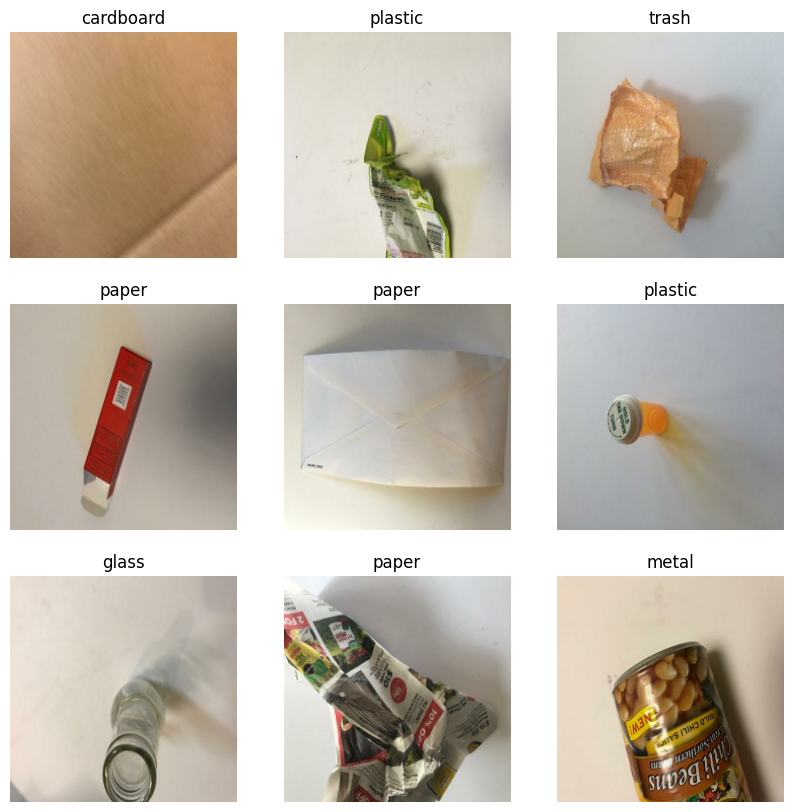

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in full_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [10]:
train_ds_for_labels = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

labels = np.concatenate([y.numpy() for x, y in train_ds_for_labels], axis=0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Class Weights: {0: np.float64(1.053125), 1: np.float64(0.8467336683417085), 2: np.float64(1.0150602409638554), 3: np.float64(0.7170212765957447), 4: np.float64(0.8553299492385786), 5: np.float64(3.1203703703703702)}


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = full_train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [13]:
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base_model.trainable = True

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,950,500 (34.14 MB)

 Trainable params: 8,868,212 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [14]:
early_stop = callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.2074 - loss: 1.8076 - val_accuracy: 0.2734 - val_loss: 1.7393
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.2863 - loss: 1.7093 - val_accuracy: 0.3281 - val_loss: 1.6683
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.3694 - loss: 1.6337 - val_accuracy: 0.4375 - val_loss: 1.5940
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - accuracy: 0.4251 - loss: 1.5539 - val_accuracy: 0.5078 - val_loss: 1.5088
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.4782 - loss: 1.4553 - val_accuracy: 0.4492 - val_loss: 1.5236
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.5288 - loss: 1.3886 - val_accuracy: 0.5312 - val_loss: 1.3450
Epoch 7/10


2025-06-22 00:02:27.567755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267968 bytes after encountering the first element of size 19267968 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


64/64 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.5523 - loss: 1.2800 - val_accuracy: 0.5586 - val_loss: 1.3216
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.5803 - loss: 1.2240 - val_accuracy: 0.6211 - val_loss: 1.2414
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.6113 - loss: 1.1459 - val_accuracy: 0.5820 - val_loss: 1.1609
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.6233 - loss: 1.0939 - val_accuracy: 0.6016 - val_loss: 1.1679


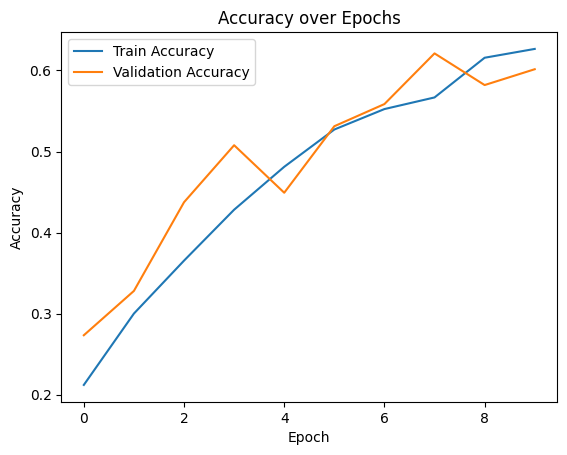

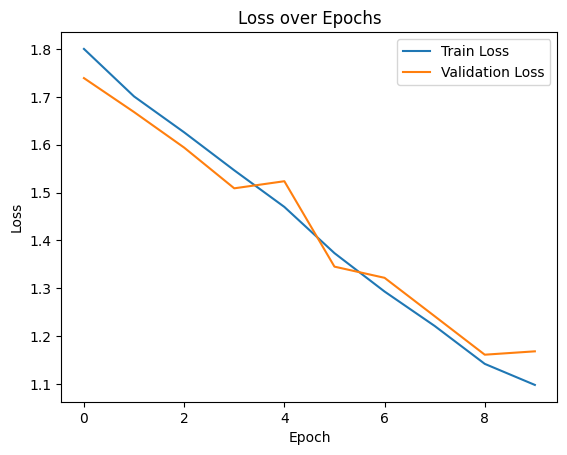

In [15]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

test_ds_for_pred = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_test_batches = tf.data.experimental.cardinality(test_ds_for_pred).numpy()
test_ds_for_pred = test_ds_for_pred.skip(val_test_batches // 2)
test_ds_for_pred = test_ds_for_pred.prefetch(tf.data.AUTOTUNE)

y_true = np.concatenate([y.numpy() for x, y in test_ds_for_pred], axis=0)
y_pred_probs = model.predict(test_ds_for_pred)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 839ms/step - accuracy: 0.6067 - loss: 1.1754
Test Accuracy: 0.61
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.11      0.09      0.10        43
       glass       0.29      0.19      0.23        47
       metal       0.11      0.08      0.09        39
       paper       0.24      0.25      0.24        61
     plastic       0.27      0.26      0.26        46
       trash       0.09      0.31      0.14        13

    accuracy                           0.19       249
   macro avg       0.18      0.20      0.18       249
weighted avg       0.20      0.19      0.19       249


Confusion Matrix:
[[ 4  5  3 13  7 11]
 [ 7  9  8 12  5  6]
 [ 8  3  3 10  7  8]
 [15  5  6 15 13  7]
 [ 3  7  5 10 12  9]
 [ 1  2  3  2  1  4]]


In [20]:
model.save("garbage_classifier.h5")
print("✅ Model saved as garbage_classifier.h5")


✅ Model saved as garbage_classifier.h5
